# A first 🤗 model

As [Lesson 4](https://course.fast.ai/Lessons/lesson4.html) of the fastai DL course deals with NLP, I decided to give this [competition](https://www.kaggle.com/competitions/feedback-prize-english-language-learning) on kaggle a try.

Many hints to how implement multi label classification can be found in [the following great notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb)

This is my first NLP model, so please make sure I didn't make any mistakes and if so, pls let me know 😀

Have fun reading ☺️

In [1]:
from datasets import Dataset,DatasetDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from transformers import AutoModelForSequenceClassification,AutoTokenizer
import torch

# Set nice style
plt.style.use(['dark_background'])

## A first look at our data

In [2]:
path = Path("feedback-prize-english-language-learning")

Get an overview of what is contained in our folder.

In [3]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [4]:
df_ss = pd.read_csv(path/"sample_submission.csv")
df_tst = pd.read_csv(path/"test.csv")
df_trn = pd.read_csv(path/"train.csv")

From [the competition site](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/data) we know that we have six different categories which determine the proficiency in essay writing of a given student. Higher scores -> Higher proficiency.

In [5]:
df_ss.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


Let's look at example of a training data.

We have for each text_id a text and the corresponding grades:

In [6]:
df_trn.head(1).T

,0
text_id,0016926B079C
full_text,I think that students would benefit from learn...
cohesion,3.5
syntax,3.5
vocabulary,3.0
phraseology,3.0
grammar,4.0
conventions,3.0


Example of a text:

In [7]:
df_trn.iloc[0].full_text

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

Let's look at the distribution of the grades:

Let's take a look of the distribution of grades:

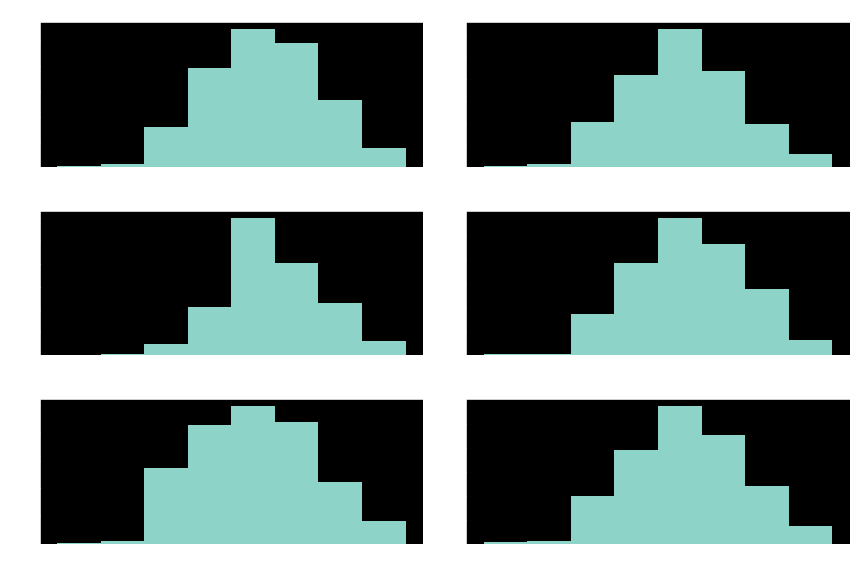

In [8]:
labels = df_trn.columns[2:]
nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol, tight_layout=True, figsize = (12,8))
for i, ax in enumerate(fig.axes):
    ax.hist(df_trn[labels[i]], bins=8);
    ax.set_title(labels[i])

We can see that there are many medium grades with just a few outliers on the left spectrum.

We should probably take this into account when building our training and validation set so that our model is also able to grade a bad student.

Let's look at the rough numbers summarized in a pretty looking data frame:

In [9]:
df_trn[labels].apply(pd.value_counts)

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
1.0,10,11,2,10,8,15
1.5,27,29,14,11,20,20
2.0,315,410,124,350,544,402
2.5,790,839,528,772,855,784
3.0,1096,1250,1503,1153,994,1151
3.5,988,867,1007,929,880,908
4.0,534,388,577,553,447,484
4.5,125,100,115,108,134,122
5.0,26,17,41,25,29,25


Especially of the vocabulary and phraseology we should take care that we sample enough examples from the $\leq 1.0$ range.

Another point of interest is the words contained in our texts. Let's check that we don't have extreme outliers as Transformers don't work good for long text inputs:

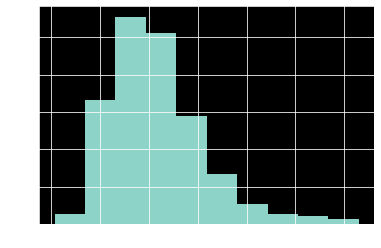

In [10]:
df_trn["full_text"].apply(lambda x: len(x.split())).hist();

We see that most texts are made of 200-600 words.

## Preprocess

To use the transformers we need a dataset.

In [11]:
ds = Dataset.from_pandas(df_trn)

In [12]:
ds

Dataset({
    features: ['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    num_rows: 3911
})

What exactly is a dataset?

Let's explore.

We have an Attribut `column_name`

In [13]:
ds.column_names

['text_id',
 'full_text',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions']

With `ds[i]`we can get the i'th element

In [14]:
ds[0]

{'text_id': '0016926B079C',
 'full_text': "I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons ca

Let's initialize our tokenizer:

In [15]:
model_nm = 'microsoft/deberta-v3-small'

In [16]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's see how exactly this works:

In [17]:
tokz.tokenize("I want to get tokenized!")

['▁I', '▁want', '▁to', '▁get', '▁token', 'ized', '!']

We can encode...

In [18]:
enc = tokz.encode(("I want to get tokenized!"))
enc

[1, 273, 409, 264, 350, 10704, 4666, 300, 2]

... and decode

In [19]:
tokz.decode(enc)

'[CLS] I want to get tokenized![SEP]'

Now we need to do 2 things:
* tokenize our data, that means transforming the text into some form the computer can process
* initialize our multi label for the model.

Let's first tackle the problem of generating categories:
* We One hot encode
* We use the resulting df to generate our dataset!

In [20]:
tempdf = pd.get_dummies(df_trn, columns=labels)

In [21]:
ds = Dataset.from_pandas(tempdf)

Split in training and validation!

In [22]:
ds_d = ds.train_test_split(0.25, seed=42)

Mapping between labels and integers

In [23]:
labels = [label for label in ds_d['train'].features.keys() if label not in ['text_id', 'full_text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels[:5]

['cohesion_1.0',
 'cohesion_1.5',
 'cohesion_2.0',
 'cohesion_2.5',
 'cohesion_3.0']

In [24]:
def preprocess_data(examples):
    # take a batch of texts
    text = examples["full_text"]
    # encode them
    encoding = tokz(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()
  
    return encoding

In [25]:
enc_ds_d = ds_d.map(preprocess_data, batched=True, remove_columns=ds_d['train'].column_names)

Parameter 'function'=<function preprocess_data at 0x7fac4afecc10> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
enc_ds_d

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2933
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 978
    })
})

Split in train and validation set

## Training

Setting up the metric...

In [27]:
def mcrmse(x,y): return np.mean(np.sqrt(np.mean((x-y)**2,axis=0)))

In [28]:
x1 = np.array([[1,1],[0,0]])
x2 = np.array([[1,0],[0,1]])

In [29]:
mcrmse(x1,x2)

0.5

In [30]:
def mcrmse_d(eval_pred): return {'mcrmse': mcrmse(*eval_pred)}

In [31]:
from transformers import TrainingArguments,Trainer

...Batch size and metric name...

In [32]:
batch_size = 8
metric_name = "mcrmse"

...the arguments...

In [33]:
args = TrainingArguments(
    f"outputs",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=8e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    mcrmse_acc = mcrmse(y_true, y_pred)
    # return as dictionary
    metrics = {'mcrmse': mcrmse_acc}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

...the model...

In [35]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_nm, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

## TRAIN!

In [36]:
enc_ds_d.set_format("torch")

Let's verify a batch as well as a forward pass:

In [37]:
enc_ds_d['train'][0]['labels'].type()

'torch.FloatTensor'

In [38]:
enc_ds_d['train']['input_ids'][0]

tensor([    1,  4136,   269,   311,   265,   262,   370,   874,   470,   267,
          291,   447,   260,  4136,   303,  1738,   265,  1451,   261,   306,
          286,   610,  6135,  4986,   334,  2858,  8202,   261,  7934,   261,
        13381,   795,  8202,   261,   263,   386,   310,   260,   450,   286,
          610, 34772,   272,   783,   360,   803,   261,   528,   355,   261,
          306,   402,   286,   347,  1085,   830,   334,   306,   286,   286,
         1090,  8926, 16224,  1013,   262,  8425,   261,   311,   265,   349,
          303,   266,  2553,  1013,   260,  1414,   273,   338,  3753,   288,
         4136,   273,   338,   472,   264,   687,   308,   645,   401,   273,
         1331,   308,   645,   284,   397,   324,  1964,   273, 40756,   834,
        31452,   278,   322,   263,   262,   645,  1127,   324, 12516,   263,
         7741,   260,   273,   338,   327,   472,   264,  2224,   277,   266,
         2750,   263,  5771,   390,   262,   707,   260,     2])

In [39]:
#forward pass
outputs = model(input_ids=enc_ds_d['train']['input_ids'][0].unsqueeze(0), labels=enc_ds_d['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6910, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.1523,  0.1020,  0.0271, -0.0094, -0.0423,  0.1312, -0.1664,  0.2214,
          0.1243,  0.0934, -0.0382, -0.1368, -0.1676,  0.0055, -0.2820, -0.0138,
          0.1081, -0.1334, -0.1276, -0.0073,  0.0665,  0.3525, -0.2512,  0.1544,
          0.1957,  0.2246,  0.1495, -0.0065, -0.1206, -0.0391,  0.0098,  0.0422,
         -0.1200,  0.1003, -0.0925, -0.0526,  0.0683, -0.2110,  0.0239,  0.1355,
          0.2869,  0.0020, -0.1044, -0.4394,  0.2157, -0.1819,  0.0900, -0.0036,
         -0.0499, -0.2271,  0.0909, -0.1022, -0.1857,  0.1304]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [40]:
trainer = Trainer(
    model,
    args,
    train_dataset=enc_ds_d["train"],
    eval_dataset=enc_ds_d["test"],
    tokenizer=tokz,
    compute_metrics=compute_metrics
)

In [41]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2933
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1835


Epoch,Training Loss,Validation Loss,Mcrmse
1,No log,0.285186,0.276595
2,0.294300,0.262396,0.277009
3,0.256900,0.258025,0.276918
4,0.256900,0.264292,0.277865
5,0.237500,0.268947,0.280089


***** Running Evaluation *****
  Num examples = 978
  Batch size = 8
Saving model checkpoint to outputs/checkpoint-367
Configuration saved in outputs/checkpoint-367/config.json
Model weights saved in outputs/checkpoint-367/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-367/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-367/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 978
  Batch size = 8
Saving model checkpoint to outputs/checkpoint-734
Configuration saved in outputs/checkpoint-734/config.json
Model weights saved in outputs/checkpoint-734/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-734/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-734/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 978
  Batch size = 8
Saving model checkpoint to outputs/checkpoint-1101
Configuration saved in outputs/checkpoint-1101/config.json
Model weights saved in outputs/chec

TrainOutput(global_step=1835, training_loss=0.2556868800025545, metrics={'train_runtime': 414.8279, 'train_samples_per_second': 35.352, 'train_steps_per_second': 4.424, 'total_flos': 486126273507840.0, 'train_loss': 0.2556868800025545, 'epoch': 5.0})

## Predict

Set up dataset

In [42]:
def tok_func(x): return tokz(x["full_text"])

In [43]:
ds_tst = Dataset.from_pandas(df_tst)

In [44]:
eval_ds = ds_tst.map(tok_func, batched=True, remove_columns=["text_id","full_text"])

  0%|          | 0/1 [00:00<?, ?ba/s]

An example for a text in the test set.

In [45]:
ds_tst[0]["full_text"][:30]

'when a person has no experienc'

In [46]:
text = ds_tst[0]["full_text"]
encoding = tokz(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

Lets convert the model outputs to probabilities!

In [47]:
logits = outputs.logits
logits.shape

torch.Size([1, 54])

In [48]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())

In each column the probability for each grade in category!

In [49]:
probs_cat = torch.reshape(probs,(6,-1))
probs_cat

tensor([[1.3449e-03, 4.0534e-03, 1.9329e-01, 4.4354e-01, 2.9212e-01, 5.5185e-02,
         4.2550e-03, 9.5515e-04, 2.5638e-04],
        [8.3035e-04, 4.3410e-03, 2.6706e-01, 5.0903e-01, 2.1249e-01, 1.7460e-02,
         2.2924e-03, 3.5820e-04, 1.7877e-04],
        [3.1327e-04, 1.2887e-03, 4.9035e-02, 3.4472e-01, 5.9424e-01, 3.5466e-02,
         5.9954e-03, 6.2657e-04, 3.3844e-04],
        [1.1110e-03, 1.2210e-03, 2.2265e-01, 4.9241e-01, 2.9399e-01, 2.3312e-02,
         4.7664e-03, 6.3960e-04, 3.5847e-04],
        [7.9150e-04, 3.1421e-03, 3.5284e-01, 4.5543e-01, 1.6734e-01, 2.3337e-02,
         3.6956e-03, 4.7873e-04, 3.8009e-04],
        [1.8744e-03, 2.8594e-03, 2.6097e-01, 4.9264e-01, 1.8876e-01, 3.0931e-02,
         2.9663e-03, 5.4795e-04, 3.0063e-04]], grad_fn=<ReshapeAliasBackward0>)

Find for each category the predicted grade!

In [50]:
pred = torch.argmax(probs_cat, axis=1)
pred

tensor([3, 3, 4, 3, 3, 3])

In [51]:
predicted_labels = [float(1 + 0.5*i) for i in pred]
predicted_labels

[2.5, 2.5, 3.0, 2.5, 2.5, 2.5]

In [52]:
preds = trainer.predict(eval_ds)

***** Running Prediction *****
  Num examples = 3
  Batch size = 8


In [53]:
preds_tt = torch.Tensor(preds.predictions)

In [54]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(preds_tt)

In [55]:
probs.shape

torch.Size([3, 54])

In [56]:
probs_cat = torch.reshape(probs,(eval_ds.num_rows,6,-1))
probs_cat

tensor([[[1.3449e-03, 4.0534e-03, 1.9329e-01, 4.4354e-01, 2.9212e-01,
          5.5185e-02, 4.2550e-03, 9.5515e-04, 2.5638e-04],
         [8.3035e-04, 4.3410e-03, 2.6706e-01, 5.0903e-01, 2.1249e-01,
          1.7460e-02, 2.2924e-03, 3.5820e-04, 1.7877e-04],
         [3.1327e-04, 1.2887e-03, 4.9035e-02, 3.4472e-01, 5.9424e-01,
          3.5466e-02, 5.9954e-03, 6.2657e-04, 3.3844e-04],
         [1.1110e-03, 1.2210e-03, 2.2265e-01, 4.9241e-01, 2.9399e-01,
          2.3312e-02, 4.7664e-03, 6.3960e-04, 3.5847e-04],
         [7.9150e-04, 3.1421e-03, 3.5284e-01, 4.5543e-01, 1.6734e-01,
          2.3337e-02, 3.6956e-03, 4.7873e-04, 3.8009e-04],
         [1.8744e-03, 2.8594e-03, 2.6097e-01, 4.9264e-01, 1.8876e-01,
          3.0931e-02, 2.9663e-03, 5.4795e-04, 3.0063e-04]],

        [[6.9702e-04, 2.2156e-03, 1.3525e-01, 4.0190e-01, 3.5979e-01,
          8.3393e-02, 6.3948e-03, 8.6993e-04, 2.2647e-04],
         [4.6869e-04, 2.0869e-03, 1.7277e-01, 5.0589e-01, 2.9519e-01,
          2.7507e-02, 3.1

In [57]:
pred = torch.argmax(probs_cat, axis=2)
pred

tensor([[3, 3, 4, 3, 3, 3],
        [3, 3, 4, 3, 3, 3],
        [5, 4, 5, 4, 4, 4]])

If we get prediction for the i'th column that means we have have for the category given by the row index

$grad_{cat} = i * 0.5 + 1$

In [58]:
grades = pred*0.5+1
grades 

tensor([[2.5000, 2.5000, 3.0000, 2.5000, 2.5000, 2.5000],
        [2.5000, 2.5000, 3.0000, 2.5000, 2.5000, 2.5000],
        [3.5000, 3.0000, 3.5000, 3.0000, 3.0000, 3.0000]])

Let's convert this to a dataframe:

In [59]:
sub = pd.DataFrame(grades.numpy())
sub.columns = df_ss.columns[1:]
sub["text_id"] = ds_tst["text_id"]
sub

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,text_id
0,2.5,2.5,3.0,2.5,2.5,2.5,0000C359D63E
1,2.5,2.5,3.0,2.5,2.5,2.5,000BAD50D026
2,3.5,3.0,3.5,3.0,3.0,3.0,00367BB2546B


In [60]:
df_ss

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


We need to rearrange the columns to get the right format.

In [61]:
sub = sub[df_ss.columns]
sub 

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.5,2.5,3.0,2.5,2.5,2.5
1,000BAD50D026,2.5,2.5,3.0,2.5,2.5,2.5
2,00367BB2546B,3.5,3.0,3.5,3.0,3.0,3.0
